# DeepFake Detection Analysis Notebook

This notebook provides comprehensive analysis and experimentation for the DeepFake Detection system.

## Contents
1. Setup and Configuration
2. Load Batch Experiment Results
3. Detection Performance Analysis
4. Comparison: Real vs Fake Videos
5. Confidence Distribution Analysis
6. Detailed Results Visualization
7. Summary and Conclusions

## 1. Setup and Configuration

In [1]:
# Import required libraries
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Optional
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# Add project to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(f"Project root: {project_root}")
print("Setup complete!")

Project root: /home/saloe/HW9/deepfake_detector
Setup complete!


## 2. Load Batch Experiment Results

This section loads results from batch experiments run with `python demo.py --batch`.

Results are stored in `results/batch_experiment_<timestamp>.json`

In [2]:
def load_latest_experiment(results_dir: Path = None) -> Optional[Dict]:
    """
    Load the most recent batch experiment results.
    """
    if results_dir is None:
        results_dir = project_root / "results"
    
    # Find all batch experiment files
    experiment_files = sorted(
        glob(str(results_dir / "batch_experiment_*.json")),
        reverse=True  # Most recent first
    )
    
    if not experiment_files:
        print("No batch experiment results found!")
        print("Run: python demo.py --batch")
        return None
    
    latest_file = experiment_files[0]
    print(f"Loading: {Path(latest_file).name}")
    
    with open(latest_file, 'r') as f:
        data = json.load(f)
    
    return data


def load_all_experiments(results_dir: Path = None) -> List[Dict]:
    """
    Load all batch experiment results.
    """
    if results_dir is None:
        results_dir = project_root / "results"
    
    experiment_files = sorted(
        glob(str(results_dir / "batch_experiment_*.json")),
        reverse=True
    )
    
    all_experiments = []
    for f in experiment_files:
        with open(f, 'r') as file:
            all_experiments.append(json.load(file))
    
    return all_experiments


# Load the latest experiment
experiment_data = load_latest_experiment()

if experiment_data:
    print(f"\nExperiment Timestamp: {experiment_data['timestamp']}")
    print(f"LLM Provider: {experiment_data['llm_provider']}")
    print(f"Model: {experiment_data['llm_model']}")
    print(f"\nSummary:")
    for key, value in experiment_data['summary'].items():
        print(f"  {key}: {value}")

Loading: batch_experiment_20260115_144915.json

Experiment Timestamp: 20260115_144915
LLM Provider: openai
Model: gpt-4-turbo

Summary:
  total_videos: 2
  correct_predictions: 1
  accuracy: 0.5
  real_videos_count: 1
  real_correct: 0
  fake_videos_count: 1
  fake_correct: 1


In [3]:
# Extract results for analysis
if experiment_data:
    results = experiment_data['results']
    
    # Separate by ground truth
    real_results = [r for r in results if r['ground_truth'] == 'REAL']
    fake_results = [r for r in results if r['ground_truth'] == 'FAKE']
    
    print(f"Total videos analyzed: {len(results)}")
    print(f"  - Real videos: {len(real_results)}")
    print(f"  - Fake videos: {len(fake_results)}")
    
    # Display detailed results
    print("\n" + "="*80)
    print("DETAILED RESULTS")
    print("="*80)
    
    for r in results:
        status = "CORRECT" if r.get('correct', False) else "INCORRECT"
        print(f"\n{r['video']}")
        print(f"  Ground Truth: {r['ground_truth']}")
        print(f"  Predicted: {r['predicted']}")
        print(f"  Confidence: {r['confidence']:.1%}")
        print(f"  Status: {status}")
else:
    results = []
    real_results = []
    fake_results = []

Total videos analyzed: 2
  - Real videos: 1
  - Fake videos: 1

DETAILED RESULTS

real_video.mp4
  Ground Truth: REAL
  Predicted: FAKE
  Confidence: 85.0%
  Status: INCORRECT

deepfake_video_example.mp4
  Ground Truth: FAKE
  Predicted: FAKE
  Confidence: 85.0%
  Status: CORRECT


## 3. Detection Performance Analysis

In [4]:
def calculate_metrics(results: List[Dict]) -> Dict:
    """
    Calculate detection performance metrics.
    """
    if not results:
        return {}
    
    # True Positives: Fake videos correctly identified as fake
    # True Negatives: Real videos correctly identified as real
    # False Positives: Real videos incorrectly identified as fake
    # False Negatives: Fake videos incorrectly identified as real
    
    tp = sum(1 for r in results if r['ground_truth'] == 'FAKE' and r['predicted'] == 'FAKE')
    tn = sum(1 for r in results if r['ground_truth'] == 'REAL' and r['predicted'] == 'REAL')
    fp = sum(1 for r in results if r['ground_truth'] == 'REAL' and r['predicted'] == 'FAKE')
    fn = sum(1 for r in results if r['ground_truth'] == 'FAKE' and r['predicted'] == 'REAL')
    
    # Handle UNCERTAIN predictions
    uncertain = sum(1 for r in results if r['predicted'] == 'UNCERTAIN')
    
    total = len(results)
    correct = tp + tn
    
    accuracy = correct / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positives': tp,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'uncertain': uncertain,
        'total': total,
    }


if results:
    metrics = calculate_metrics(results)
    
    print("DETECTION PERFORMANCE METRICS")
    print("="*50)
    print(f"\nAccuracy:  {metrics['accuracy']:.1%}")
    print(f"Precision: {metrics['precision']:.1%}")
    print(f"Recall:    {metrics['recall']:.1%}")
    print(f"F1 Score:  {metrics['f1_score']:.3f}")
    print(f"\nConfusion Matrix:")
    print(f"  True Positives (Fake detected as Fake): {metrics['true_positives']}")
    print(f"  True Negatives (Real detected as Real): {metrics['true_negatives']}")
    print(f"  False Positives (Real detected as Fake): {metrics['false_positives']}")
    print(f"  False Negatives (Fake detected as Real): {metrics['false_negatives']}")
    if metrics['uncertain'] > 0:
        print(f"  Uncertain: {metrics['uncertain']}")

DETECTION PERFORMANCE METRICS

Accuracy:  50.0%
Precision: 50.0%
Recall:    100.0%
F1 Score:  0.667

Confusion Matrix:
  True Positives (Fake detected as Fake): 1
  True Negatives (Real detected as Real): 0
  False Positives (Real detected as Fake): 1
  False Negatives (Fake detected as Real): 0


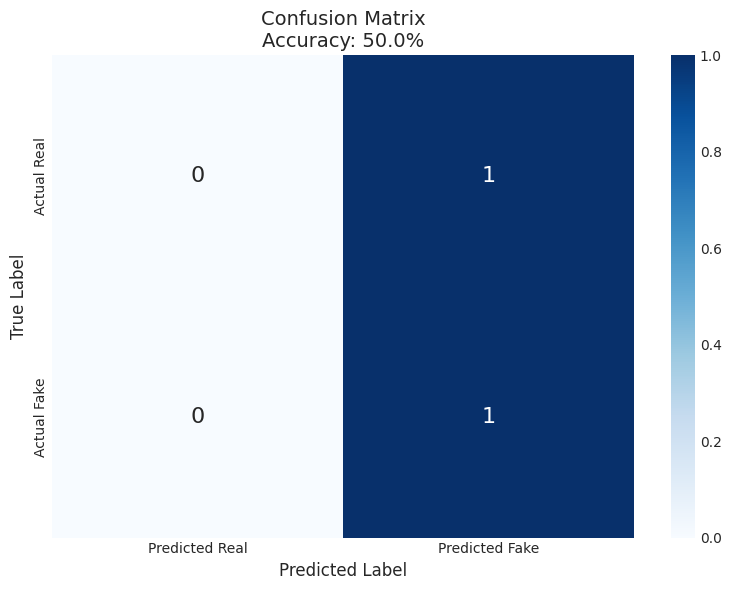


Confusion matrix saved to 'confusion_matrix.png'


In [5]:
# Visualize Confusion Matrix
if results and len(results) > 0:
    metrics = calculate_metrics(results)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    cm = np.array([
        [metrics['true_negatives'], metrics['false_positives']],
        [metrics['false_negatives'], metrics['true_positives']]
    ])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Predicted Real', 'Predicted Fake'],
                yticklabels=['Actual Real', 'Actual Fake'],
                annot_kws={'size': 16})
    
    ax.set_title(f'Confusion Matrix\nAccuracy: {metrics["accuracy"]:.1%}', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nConfusion matrix saved to 'confusion_matrix.png'")
else:
    print("No results to visualize. Run batch experiment first.")

## 4. Comparison: Real vs Fake Videos

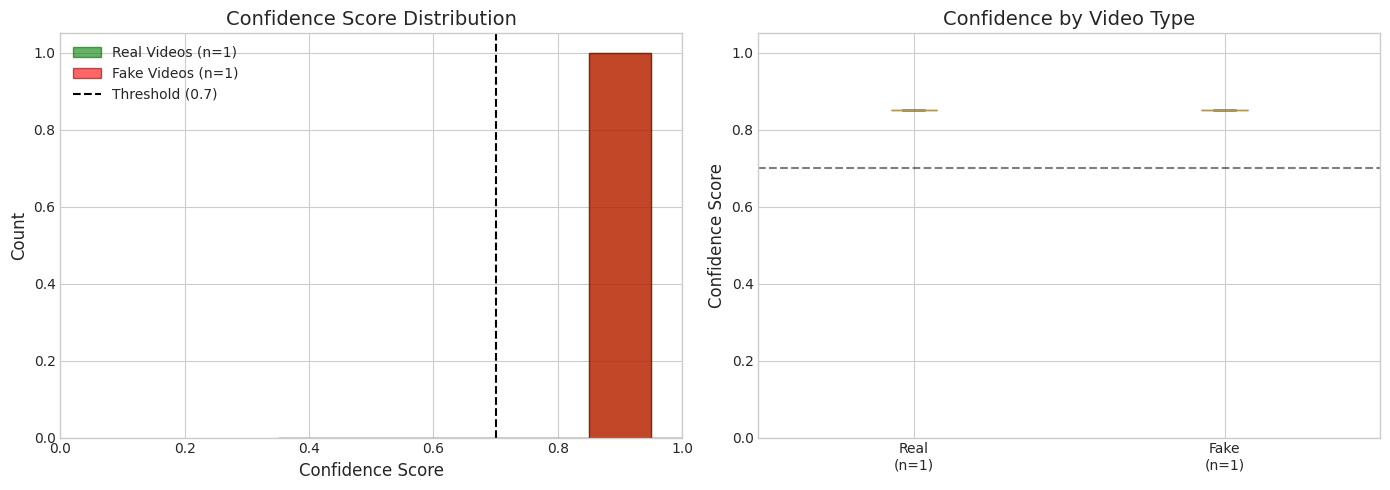


Confidence comparison saved to 'confidence_comparison.png'


In [6]:
# Compare confidence scores between real and fake videos
if results and len(results) > 0:
    real_confidences = [r['confidence'] for r in real_results if r.get('confidence')]
    fake_confidences = [r['confidence'] for r in fake_results if r.get('confidence')]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confidence Distribution
    ax1 = axes[0]
    if real_confidences:
        ax1.hist(real_confidences, bins=10, alpha=0.6, label=f'Real Videos (n={len(real_confidences)})', 
                color='green', edgecolor='darkgreen')
    if fake_confidences:
        ax1.hist(fake_confidences, bins=10, alpha=0.6, label=f'Fake Videos (n={len(fake_confidences)})', 
                color='red', edgecolor='darkred')
    ax1.axvline(x=0.7, color='black', linestyle='--', label='Threshold (0.7)')
    ax1.set_xlabel('Confidence Score', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Confidence Score Distribution', fontsize=14)
    ax1.legend()
    ax1.set_xlim(0, 1)
    
    # Box Plot
    ax2 = axes[1]
    data_to_plot = []
    labels = []
    colors = []
    
    if real_confidences:
        data_to_plot.append(real_confidences)
        labels.append(f'Real\n(n={len(real_confidences)})')
        colors.append('green')
    if fake_confidences:
        data_to_plot.append(fake_confidences)
        labels.append(f'Fake\n(n={len(fake_confidences)})')
        colors.append('red')
    
    if data_to_plot:
        bp = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.5)
    
    ax2.axhline(y=0.7, color='black', linestyle='--', alpha=0.5, label='Threshold')
    ax2.set_ylabel('Confidence Score', fontsize=12)
    ax2.set_title('Confidence by Video Type', fontsize=14)
    ax2.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.savefig('confidence_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nConfidence comparison saved to 'confidence_comparison.png'")
else:
    print("No results to visualize. Run batch experiment first.")

## 5. Per-Video Analysis

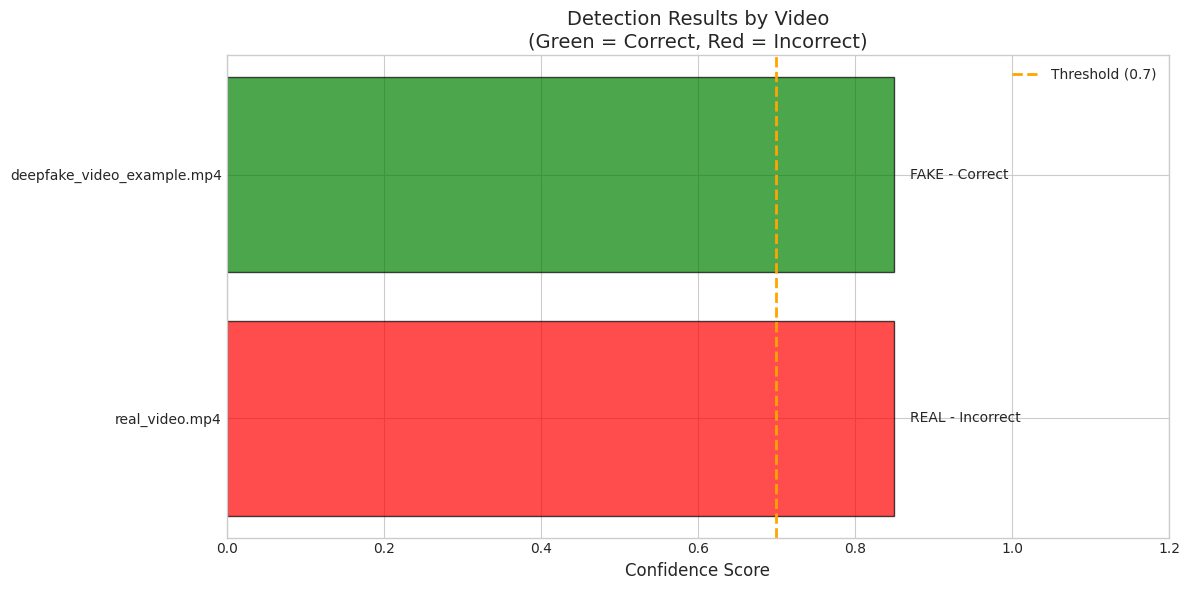


Per-video analysis saved to 'per_video_analysis.png'


In [7]:
# Create a detailed per-video analysis
if results and len(results) > 0:
    fig, ax = plt.subplots(figsize=(12, max(6, len(results) * 0.5)))
    
    videos = [r['video'] for r in results]
    confidences = [r['confidence'] for r in results]
    colors = ['green' if r['correct'] else 'red' for r in results]
    ground_truths = [r['ground_truth'] for r in results]
    
    y_pos = np.arange(len(videos))
    
    bars = ax.barh(y_pos, confidences, color=colors, alpha=0.7, edgecolor='black')
    
    # Add labels
    for i, (bar, gt, conf, correct) in enumerate(zip(bars, ground_truths, confidences, [r['correct'] for r in results])):
        status = "Correct" if correct else "Incorrect"
        ax.text(conf + 0.02, i, f'{gt} - {status}', va='center', fontsize=10)
    
    ax.axvline(x=0.7, color='orange', linestyle='--', linewidth=2, label='Threshold (0.7)')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(videos)
    ax.set_xlabel('Confidence Score', fontsize=12)
    ax.set_title('Detection Results by Video\n(Green = Correct, Red = Incorrect)', fontsize=14)
    ax.set_xlim(0, 1.2)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig('per_video_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nPer-video analysis saved to 'per_video_analysis.png'")
else:
    print("No results to visualize. Run batch experiment first.")

## 6. Processing Time Analysis

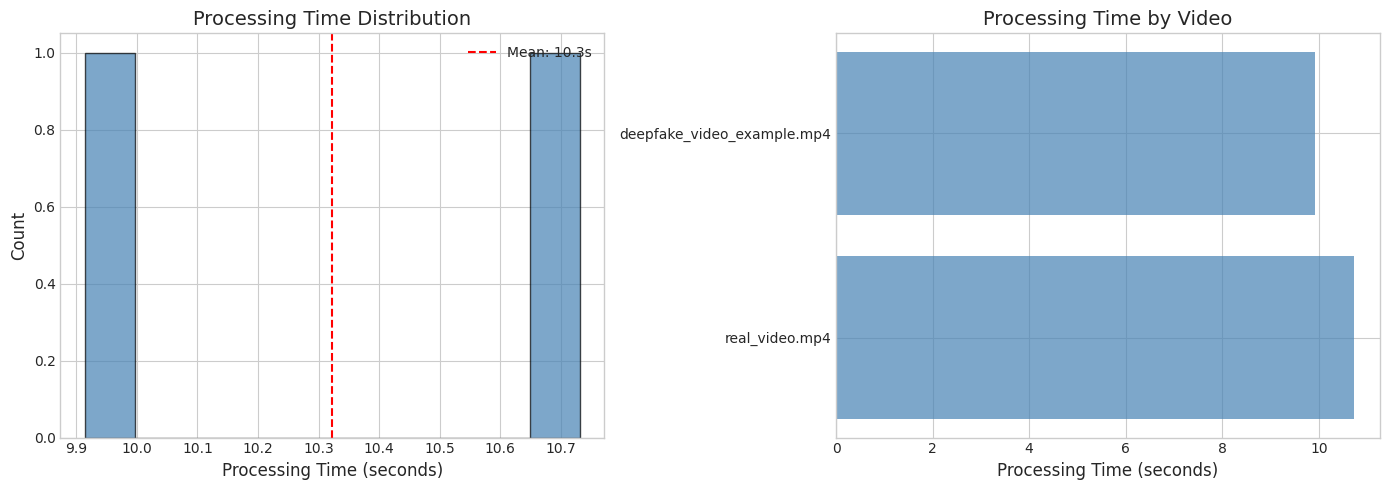


Processing Time Statistics:
  Mean: 10.32s
  Median: 10.32s
  Min: 9.91s
  Max: 10.73s
  Total: 20.65s

Processing time analysis saved to 'processing_time_analysis.png'


In [8]:
# Analyze processing times
if results and len(results) > 0:
    processing_times = [r.get('processing_time', 0) for r in results if r.get('processing_time')]
    
    if processing_times:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Histogram
        ax1 = axes[0]
        ax1.hist(processing_times, bins=10, color='steelblue', edgecolor='black', alpha=0.7)
        ax1.axvline(x=np.mean(processing_times), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(processing_times):.1f}s')
        ax1.set_xlabel('Processing Time (seconds)', fontsize=12)
        ax1.set_ylabel('Count', fontsize=12)
        ax1.set_title('Processing Time Distribution', fontsize=14)
        ax1.legend()
        
        # Per-video bar chart
        ax2 = axes[1]
        videos_with_time = [(r['video'], r.get('processing_time', 0)) for r in results if r.get('processing_time')]
        videos, times = zip(*videos_with_time)
        y_pos = np.arange(len(videos))
        ax2.barh(y_pos, times, color='steelblue', alpha=0.7)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(videos)
        ax2.set_xlabel('Processing Time (seconds)', fontsize=12)
        ax2.set_title('Processing Time by Video', fontsize=14)
        
        plt.tight_layout()
        plt.savefig('processing_time_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\nProcessing Time Statistics:")
        print(f"  Mean: {np.mean(processing_times):.2f}s")
        print(f"  Median: {np.median(processing_times):.2f}s")
        print(f"  Min: {np.min(processing_times):.2f}s")
        print(f"  Max: {np.max(processing_times):.2f}s")
        print(f"  Total: {np.sum(processing_times):.2f}s")
        print("\nProcessing time analysis saved to 'processing_time_analysis.png'")
    else:
        print("No processing time data available.")
else:
    print("No results to visualize. Run batch experiment first.")

## 7. Multiple Experiment Comparison

Compare results across multiple batch experiments.

In [9]:
# Load and compare all experiments
all_experiments = load_all_experiments()

if all_experiments and len(all_experiments) > 1:
    print(f"Found {len(all_experiments)} experiments to compare")
    print("\n" + "="*80)
    print("EXPERIMENT COMPARISON")
    print("="*80)
    
    comparison_data = []
    
    for exp in all_experiments:
        summary = exp['summary']
        comparison_data.append({
            'timestamp': exp['timestamp'],
            'model': exp['llm_model'],
            'total': summary['total_videos'],
            'accuracy': summary['accuracy'],
            'real_correct': summary.get('real_correct', 0),
            'fake_correct': summary.get('fake_correct', 0),
        })
        
        print(f"\nExperiment: {exp['timestamp']}")
        print(f"  Model: {exp['llm_model']}")
        print(f"  Accuracy: {summary['accuracy']:.1%}")
        print(f"  Videos: {summary['total_videos']}")
    
    # Plot comparison if we have multiple experiments
    if len(comparison_data) >= 2:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        timestamps = [d['timestamp'] for d in comparison_data]
        accuracies = [d['accuracy'] for d in comparison_data]
        
        ax.bar(range(len(timestamps)), accuracies, color='steelblue', alpha=0.7)
        ax.set_xticks(range(len(timestamps)))
        ax.set_xticklabels(timestamps, rotation=45, ha='right')
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.set_title('Accuracy Across Experiments', fontsize=14)
        ax.set_ylim(0, 1.05)
        
        for i, acc in enumerate(accuracies):
            ax.text(i, acc + 0.02, f'{acc:.1%}', ha='center', fontsize=10)
        
        plt.tight_layout()
        plt.savefig('experiment_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\nExperiment comparison saved to 'experiment_comparison.png'")
else:
    print("Need at least 2 experiments to compare.")
    print("Run multiple batch experiments with: python demo.py --batch")

Need at least 2 experiments to compare.
Run multiple batch experiments with: python demo.py --batch


## 8. Summary and Conclusions

In [10]:
# Generate final summary report
print("="*80)
print("          DEEPFAKE DETECTION SYSTEM - ANALYSIS SUMMARY")
print("="*80)

if experiment_data:
    summary = experiment_data['summary']
    
    print(f"\n1. EXPERIMENT DETAILS")
    print("-"*40)
    print(f"   Timestamp: {experiment_data['timestamp']}")
    print(f"   LLM Provider: {experiment_data['llm_provider']}")
    print(f"   Model: {experiment_data['llm_model']}")
    
    print(f"\n2. DATASET")
    print("-"*40)
    print(f"   Total Videos: {summary['total_videos']}")
    print(f"   Real Videos: {summary['real_videos_count']}")
    print(f"   Fake Videos: {summary['fake_videos_count']}")
    
    print(f"\n3. PERFORMANCE METRICS")
    print("-"*40)
    print(f"   Overall Accuracy: {summary['accuracy']:.1%}")
    if summary['real_videos_count'] > 0:
        real_acc = summary['real_correct'] / summary['real_videos_count']
        print(f"   Real Video Accuracy: {real_acc:.1%} ({summary['real_correct']}/{summary['real_videos_count']})")
    if summary['fake_videos_count'] > 0:
        fake_acc = summary['fake_correct'] / summary['fake_videos_count']
        print(f"   Fake Video Accuracy: {fake_acc:.1%} ({summary['fake_correct']}/{summary['fake_videos_count']})")
    
    # Calculate and display additional metrics
    if results:
        metrics = calculate_metrics(results)
        print(f"   Precision: {metrics['precision']:.1%}")
        print(f"   Recall: {metrics['recall']:.1%}")
        print(f"   F1 Score: {metrics['f1_score']:.3f}")
    
    print(f"\n4. GENERATED VISUALIZATIONS")
    print("-"*40)
    print("   - confusion_matrix.png")
    print("   - confidence_comparison.png")
    print("   - per_video_analysis.png")
    print("   - processing_time_analysis.png")
    if len(all_experiments) > 1:
        print("   - experiment_comparison.png")
    
    print(f"\n5. RECOMMENDATIONS")
    print("-"*40)
    if summary['accuracy'] < 0.7:
        print("   - Consider adding more diverse training samples")
        print("   - Try different LLM models for better reasoning")
    else:
        print("   - System performing well on current dataset")
        print("   - Consider testing on larger, more diverse datasets")
else:
    print("\nNo experiment data available.")
    print("\nTo run a batch experiment:")
    print("  1. Place real videos in: data/samples/real/")
    print("  2. Place fake videos in: data/samples/fake/")
    print("  3. Run: python demo.py --batch")

print("\n" + "="*80)
print("                    Analysis Complete!")
print("="*80)

          DEEPFAKE DETECTION SYSTEM - ANALYSIS SUMMARY

1. EXPERIMENT DETAILS
----------------------------------------
   Timestamp: 20260115_144915
   LLM Provider: openai
   Model: gpt-4-turbo

2. DATASET
----------------------------------------
   Total Videos: 2
   Real Videos: 1
   Fake Videos: 1

3. PERFORMANCE METRICS
----------------------------------------
   Overall Accuracy: 50.0%
   Real Video Accuracy: 0.0% (0/1)
   Fake Video Accuracy: 100.0% (1/1)
   Precision: 50.0%
   Recall: 100.0%
   F1 Score: 0.667

4. GENERATED VISUALIZATIONS
----------------------------------------
   - confusion_matrix.png
   - confidence_comparison.png
   - per_video_analysis.png
   - processing_time_analysis.png

5. RECOMMENDATIONS
----------------------------------------
   - Consider adding more diverse training samples
   - Try different LLM models for better reasoning

                    Analysis Complete!


## 9. How to Add More Videos

To run experiments with additional videos:

1. **Add Real Videos:**
   ```bash
   cp your_real_video.mp4 data/samples/real/
   ```

2. **Add Fake Videos:**
   ```bash
   cp your_deepfake_video.mp4 data/samples/fake/
   ```

3. **Run Batch Experiment:**
   ```bash
   python demo.py --batch
   ```

4. **Re-run this notebook** to analyze the new results.

The system supports: MP4, AVI, MOV, MKV, WebM formats.